In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import pandas as pd
import mdtraj as md

In [2]:
pdb = '/home/exx/Downloads/nmrgnn/ligand.pdb'
trajectory = '/home/exx/Downloads/nmrgnn/lig_full_traj.dcd'
outdir = '/home/exx/Downloads/nmrgnn/output/'
if not os.path.exists('outdir/'):
     os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)   

outdir: /home/exx/Downloads/nmrgnn/output/
pdb: /home/exx/Downloads/nmrgnn/ligand.pdb
trjaectory: /home/exx/Downloads/nmrgnn/lig_full_traj.dcd


In [3]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [4]:
atoms, bonds = trj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C,C,58,LIG,0,
1,2,C1,C,58,LIG,0,
2,3,C2,C,58,LIG,0,
3,4,C3,C,58,LIG,0,
4,5,C4,C,58,LIG,0,
...,...,...,...,...,...,...,...
56,57,H23,H,58,LIG,0,
57,58,H24,H,58,LIG,0,
58,59,H25,H,58,LIG,0,
59,60,H26,H,58,LIG,0,


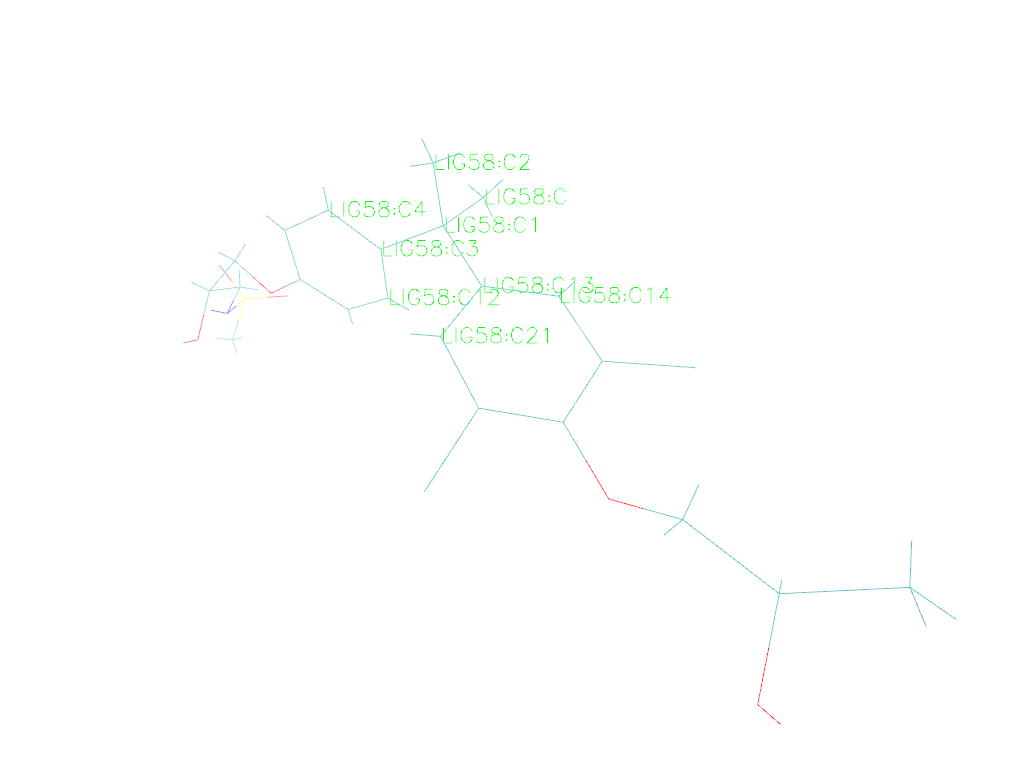

In [5]:
from IPython.display import Image
Image(filename= "/home/exx/Downloads/nmrgnn/ligand1.png") 

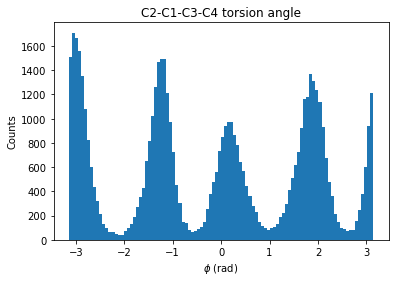

In [6]:
phi_indices = [2, 1, 3, 4] # atoms to define the torsion angle
phi = md.compute_dihedrals(trj, [phi_indices])

phicounts, binedges, otherstuff = plt.hist(phi, bins=100) # create a histogram with 90 bins
plt.title('C2-C1-C3-C4 torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

Text(0, 0.5, 'phi radians')

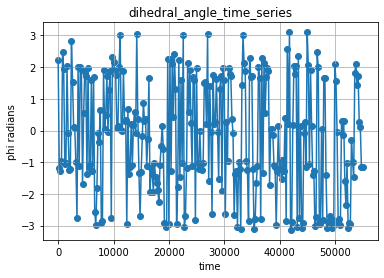

In [7]:
time_series = np.linspace(0, 55157, 55157)
plt.plot(time_series[::200], phi[::200])
plt.scatter(time_series[::200], phi[::200])
plt.grid()
plt.title("dihedral_angle_time_series")
plt.xlabel("time")
plt.ylabel("phi radians")

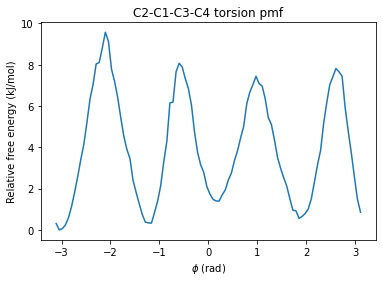

In [8]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('C2-C1-C3-C4 torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.savefig("evsphi.png")
plt.show()

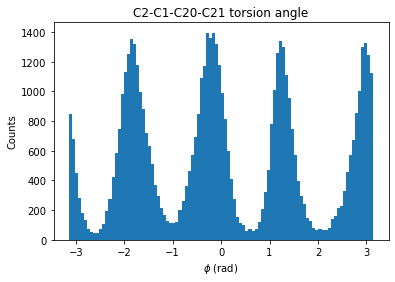

In [9]:
phi_indices_1 = [2, 1, 20, 21] # atoms to define the torsion angle
phi_1 = md.compute_dihedrals(trj, [phi_indices_1])
phicounts, binedges, otherstuff = plt.hist(phi_1, bins=100) # create a histogram with 90 bins
plt.title('C2-C1-C20-C21 torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

Text(0, 0.5, 'phi radians')

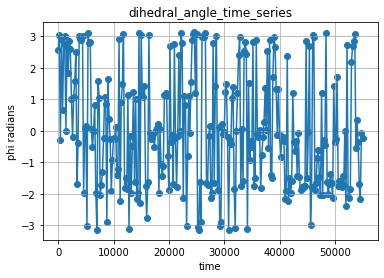

In [10]:
time_series = np.linspace(0, 55157, 55157)
plt.plot(time_series[::200], phi_1[::200])
plt.scatter(time_series[::200], phi_1[::200])
plt.grid()
plt.title("dihedral_angle_time_series")
plt.xlabel("time")
plt.ylabel("phi radians")

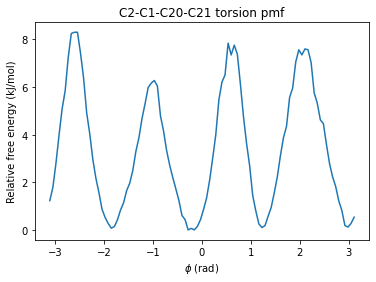

In [13]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('C2-C1-C20-C21 torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

In [12]:
data = pd.read_csv('/home/exx/Downloads/nmrgnn/ligand.csv', header=None)

/home/exx/miniconda3/envs/New_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (0,2,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
A = data[(data== 'C1').any(axis=1)]
print(A)

         0    1   2   3      4     5                    6      7
2        1  LIG  58  C1  57.26  True                  0.0      0
63       1  LIG  58  C1  57.57  True           0.04888821      1
124      1  LIG  58  C1  57.38  True           0.09777642      2
185      1  LIG  58  C1  56.34  True  0.14666463000000002      3
246      1  LIG  58  C1  62.12  True           0.19555284      4
...     ..  ...  ..  ..    ...   ...                  ...    ...
3364274  1  LIG  58  C1  61.32  True          2696.282558  55152
3364335  1  LIG  58  C1  55.14  True          2696.331446  55153
3364396  1  LIG  58  C1  57.54  True          2696.380334  55154
3364457  1  LIG  58  C1  63.31  True          2696.429223  55155
3364518  1  LIG  58  C1  53.29  True          2696.478111  55156

[55157 rows x 8 columns]


In [15]:
time_series = np.linspace(0, 55157, 55157)
trunc = A[4][::200].astype(float)
trunc_time = time_series[::200]

Text(0.5, 15.0, 'time')

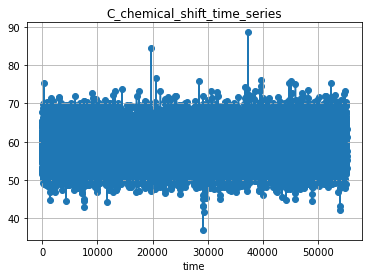

In [16]:
chem_shifts_C= A[4].astype(float)
plt.plot(time_series, chem_shifts_C)
plt.scatter(time_series, chem_shifts_C)
plt.grid()
plt.title("C_chemical_shift_time_series")
plt.savefig("chemshifttimeseries.png")
plt.xlabel("time")

Text(0.5, 15.0, 'time')

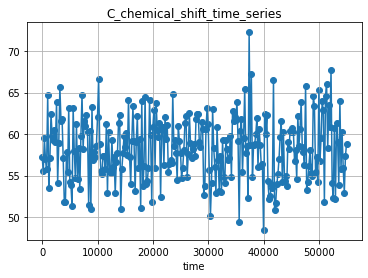

In [17]:
plt.plot(trunc_time, trunc)
plt.scatter(trunc_time, trunc)
plt.grid()
plt.title("C_chemical_shift_time_series")
plt.savefig("trun_cs_time_series.png")
plt.xlabel("time")

In [18]:
basin_1 = np.where((phi<-2.5)|(phi>2.5))
basin_2 = np.where((phi>-2)&(phi<-0.5))
basin_3 = np.where((phi>-0.5)&(phi<1))
basin_4 = np.where((phi>1)&(phi<2.5))

In [20]:
cs = A[4].to_numpy()
basin1_cs = cs[basin_1[0]].astype(np.float32)
basin2_cs = cs[basin_2[0]].astype(np.float32)
basin3_cs = cs[basin_3[0]].astype(np.float32)
basin4_cs = cs[basin_4[0]].astype(np.float32)

In [21]:
basin1_std = np.std(basin1_cs)
basin2_std = np.std(basin2_cs)
basin3_std = np.std(basin3_cs)
basin4_std = np.std(basin4_cs)

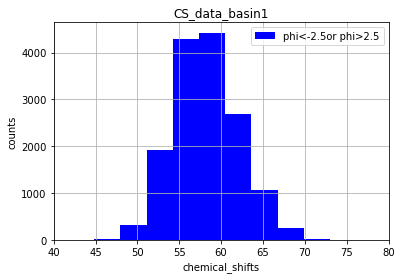

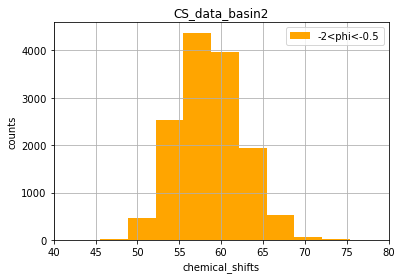

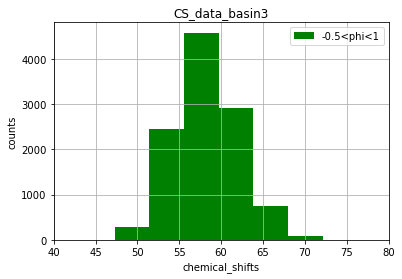

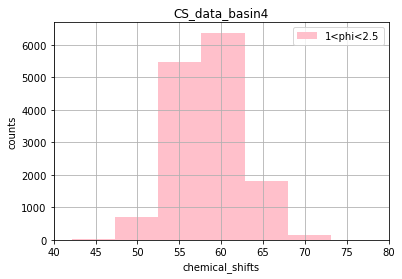

In [22]:
plt.hist(basin1_cs, bins=10, label="phi<-2.5or phi>2.5", color='b')
plt.grid()
plt.xlabel("chemical_shifts")
plt.ylabel("counts")
plt.legend()
plt.xlim(40,80)
plt.title("CS_data_basin1")
# plt.savefig("CS-basin1.png")
plt.show()



plt.hist(basin2_cs, bins=10, label="-2<phi<-0.5", color='orange')
plt.grid()
plt.xlabel("chemical_shifts")
plt.ylabel("counts")
plt.legend()
plt.xlim(40,80)
plt.title("CS_data_basin2")
# plt.savefig("CS-basin2.png")
plt.show()



plt.hist(basin3_cs, bins=10, label="-0.5<phi<1", color="g")
plt.grid()
plt.xlabel("chemical_shifts")
plt.ylabel("counts")
plt.legend()
plt.xlim(40,80)
plt.title("CS_data_basin3")
# plt.savefig("CS-basin3.png")
plt.show()

plt.hist(basin4_cs, bins=10, label="1<phi<2.5", color="pink")
plt.grid()
plt.xlabel("chemical_shifts")
plt.ylabel("counts")
plt.legend()
plt.xlim(40,80)
plt.title("CS_data_basin4")
# plt.savefig("CS-basin4.png")
plt.show()

In [23]:
data_list = [basin1_cs, basin2_cs, basin3_cs, basin4_cs]
labels = ["basin{}".format(i) for i in range(1,5)]

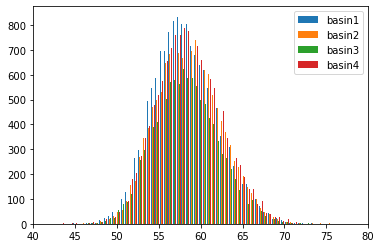

In [24]:
plt.hist(data_list, label=labels, bins=100)
plt.xlim(40,80)
plt.legend()
plt.savefig("cs_data_histogram.png")

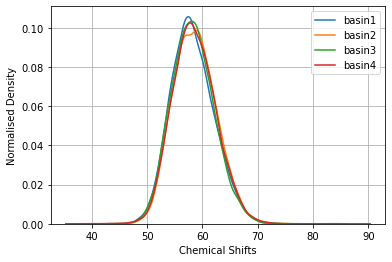

In [25]:
for data,label in zip(data_list,labels):
    sns.kdeplot(data,label=label)
plt.legend()
plt.grid()
plt.xlabel("Chemical Shifts")
plt.ylabel("Normalised Density")
plt.savefig("densityplotbasins.png")

In [26]:
data_list = [basin1_cs, basin2_cs, basin3_cs, basin4_cs]
labels = ["basin{}".format(i) for i in range(1,5)]

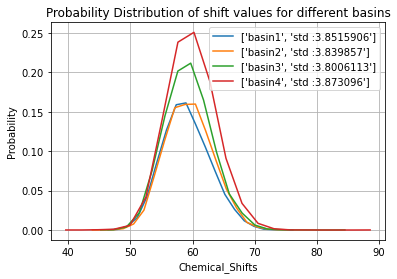

In [27]:
count1, edges1 = np.histogram(basin1_cs, bins = 20)
density_angle1 = count1 / np.sum(count1)


count2, edges2 = np.histogram(basin2_cs, bins=20)
density_angle2 = count2 / np.sum(count2)

count3, edges3 = np.histogram(basin3_cs, bins=20)
density_angle3 = count3 / np.sum(count3)

count4, edges4 = np.histogram(basin4_cs, bins=20)
density_angle4 = count4 / np.sum(count4)



plt.plot(edges1[1:], density_angle1, label=["basin1", "std :"+str(basin1_std)])
plt.plot(edges2[1:], density_angle2, label=["basin2", "std :" + str(basin2_std)])
plt.plot(edges3[1:], density_angle3, label= ["basin3","std :"+str(basin3_std)])
plt.plot(edges4[1:], density_angle4, label=["basin4", "std :" +str(basin4_std)])

plt.xlabel("Chemical_Shifts")
plt.ylabel("Probability")
plt.title("Probability Distribution of shift values for different basins")
plt.grid()
plt.legend()
plt.savefig("CentralCbasins.png")
plt.show()  

In [28]:
cs_data = pd.read_csv('/home/exx/Downloads/nmrgnn/ligand.csv', header=None)

/home/exx/miniconda3/envs/New_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (0,2,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
B = cs_data[(cs_data== 'C13').any(axis=1)]
print(B)

          0    1   2    3       4     5                    6      7
21       20  LIG  58  C13  155.43  True                  0.0      0
82       20  LIG  58  C13  145.96  True           0.04888821      1
143      20  LIG  58  C13  153.28  True           0.09777642      2
204      20  LIG  58  C13  155.13  True  0.14666463000000002      3
265      20  LIG  58  C13  150.06  True           0.19555284      4
...      ..  ...  ..  ...     ...   ...                  ...    ...
3364293  20  LIG  58  C13  151.67  True          2696.282558  55152
3364354  20  LIG  58  C13   153.3  True          2696.331446  55153
3364415  20  LIG  58  C13  163.96  True          2696.380334  55154
3364476  20  LIG  58  C13  147.61  True          2696.429223  55155
3364537  20  LIG  58  C13  163.87  True          2696.478111  55156

[55157 rows x 8 columns]


In [31]:
c13_cs = B[4].to_numpy()
basin1_c13 = c13_cs[basin_1[0]].astype(np.float32)
basin2_c13 = c13_cs[basin_2[0]].astype(np.float32)
basin3_c13 = c13_cs[basin_3[0]].astype(np.float32)
basin4_c13 = c13_cs[basin_4[0]].astype(np.float32)

basin1_c13std = np.std(basin1_c13)
basin2_c13std = np.std(basin2_c13)
basin3_c13std = np.std(basin3_c13)
basin4_c13std = np.std(basin4_c13)

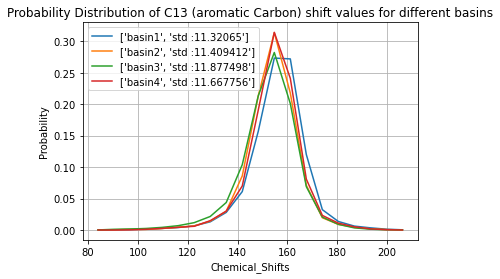

In [32]:
count1, edges1 = np.histogram(basin1_c13, bins = 20)
density_angle1 = count1 / np.sum(count1)


count2, edges2 = np.histogram(basin2_c13, bins=20)
density_angle2 = count2 / np.sum(count2)

count3, edges3 = np.histogram(basin3_c13, bins=20)
density_angle3 = count3 / np.sum(count3)

count4, edges4 = np.histogram(basin4_c13, bins=20)
density_angle4 = count4 / np.sum(count4)


plt.plot(edges1[1:], density_angle1, label=["basin1", "std :"+str(basin1_c13std)])
plt.plot(edges1[1:], density_angle2, label=["basin2", "std :"+str(basin2_c13std)])
plt.plot(edges1[1:], density_angle3, label=["basin3", "std :"+str(basin3_c13std)])
plt.plot(edges1[1:], density_angle4, label=["basin4", "std :"+str(basin4_c13std)])



plt.xlabel("Chemical_Shifts")
plt.ylabel("Probability")
plt.title("Probability Distribution of C13 (aromatic Carbon) shift values for different basins")
plt.grid()
plt.legend()
#plt.savefig("C13.png")
plt.show()  

In [33]:
C = cs_data[(cs_data== 'C3').any(axis=1)]

c3_cs = C[4].to_numpy()
basin1_c3 = c3_cs[basin_1[0]].astype(np.float32)
basin2_c3 = c3_cs[basin_2[0]].astype(np.float32)
basin3_c3 = c3_cs[basin_3[0]].astype(np.float32)
basin4_c3 = c3_cs[basin_4[0]].astype(np.float32)

basin1_c3std = np.std(basin1_c3)
basin2_c3std = np.std(basin2_c3)
basin3_c3std = np.std(basin3_c3)
basin4_c3std = np.std(basin4_c3)

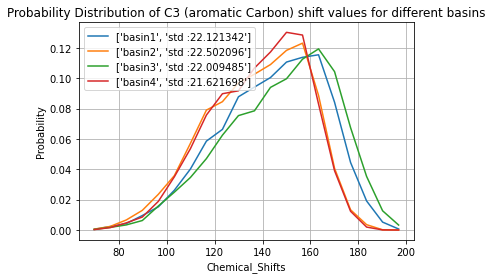

In [34]:
count1, edges1 = np.histogram(basin1_c3, bins = 20)
density_angle1 = count1 / np.sum(count1)


count2, edges2 = np.histogram(basin2_c3, bins=20)
density_angle2 = count2 / np.sum(count2)

count3, edges3 = np.histogram(basin3_c3, bins=20)
density_angle3 = count3 / np.sum(count3)

count4, edges4 = np.histogram(basin4_c3, bins=20)
density_angle4 = count4 / np.sum(count4)


plt.plot(edges1[1:], density_angle1, label=["basin1", "std :"+str(basin1_c3std)])
plt.plot(edges1[1:], density_angle2, label=["basin2", "std :"+str(basin2_c3std)])
plt.plot(edges1[1:], density_angle3, label=["basin3", "std :"+str(basin3_c3std)])
plt.plot(edges1[1:], density_angle4, label=["basin4", "std :"+str(basin4_c3std)])




plt.xlabel("Chemical_Shifts")
plt.ylabel("Probability")
plt.title("Probability Distribution of C3 (aromatic Carbon) shift values for different basins")
plt.grid()
plt.legend()
plt.show()

In [36]:
D = cs_data[(cs_data== 'C2').any(axis=1)]

c2_cs = D[4].to_numpy()
basin1_c2 = c2_cs[basin_1[0]].astype(np.float32)
basin2_c2 = c2_cs[basin_2[0]].astype(np.float32)
basin3_c2 = c2_cs[basin_3[0]].astype(np.float32)
basin4_c2 = c2_cs[basin_4[0]].astype(np.float32)

basin1_c2std = np.std(basin1_c2)
basin2_c2std = np.std(basin2_c2)
basin3_c2std = np.std(basin3_c2)
basin4_c2std = np.std(basin4_c2)

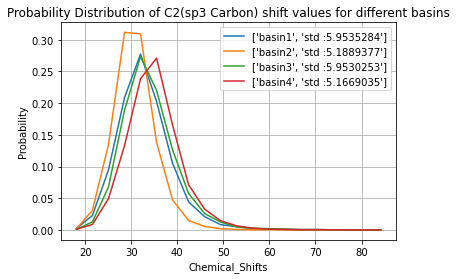

In [37]:
count1, edges1 = np.histogram(basin1_c2, bins = 20)
density_angle1 = count1 / np.sum(count1)


count2, edges2 = np.histogram(basin2_c2, bins=20)
density_angle2 = count2 / np.sum(count2)

count3, edges3 = np.histogram(basin3_c2, bins=20)
density_angle3 = count3 / np.sum(count3)

count4, edges4 = np.histogram(basin4_c2, bins=20)
density_angle4 = count4 / np.sum(count4)

plt.plot(edges1[1:], density_angle1, label=["basin1", "std :"+str(basin1_c2std)])
plt.plot(edges1[1:], density_angle2, label=["basin2", "std :"+str(basin2_c2std)])
plt.plot(edges1[1:], density_angle3, label=["basin3", "std :"+str(basin3_c2std)])
plt.plot(edges1[1:], density_angle4, label=["basin4", "std :"+str(basin4_c2std)])


plt.xlabel("Chemical_Shifts")
plt.ylabel("Probability")
plt.title("Probability Distribution of C2(sp3 Carbon) shift values for different basins")
plt.grid()
plt.legend()
plt.show()

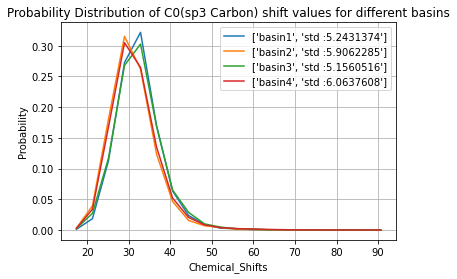

In [39]:
E = cs_data[(cs_data== 'C').any(axis=1)]

c_cs = E[4].to_numpy()
basin1_c = c_cs[basin_1[0]].astype(np.float32)
basin2_c = c_cs[basin_2[0]].astype(np.float32)
basin3_c = c_cs[basin_3[0]].astype(np.float32)
basin4_c = c_cs[basin_4[0]].astype(np.float32)

basin1_cstd = np.std(basin1_c)
basin2_cstd = np.std(basin2_c)
basin3_cstd = np.std(basin3_c)
basin4_cstd = np.std(basin4_c)

count1, edges1 = np.histogram(basin1_c, bins = 20)
density_angle1 = count1 / np.sum(count1)


count2, edges2 = np.histogram(basin2_c, bins=20)
density_angle2 = count2 / np.sum(count2)

count3, edges3 = np.histogram(basin3_c, bins=20)
density_angle3 = count3 / np.sum(count3)

count4, edges4 = np.histogram(basin4_c, bins=20)
density_angle4 = count4 / np.sum(count4)



plt.plot(edges1[1:], density_angle1, label=["basin1", "std :"+str(basin1_cstd)])
plt.plot(edges1[1:], density_angle2, label=["basin2", "std :"+str(basin2_cstd)])
plt.plot(edges1[1:], density_angle3, label=["basin3", "std :"+str(basin3_cstd)])
plt.plot(edges1[1:], density_angle4, label=["basin4", "std :"+str(basin4_cstd)])


plt.xlabel("Chemical_Shifts")
plt.ylabel("Probability")
plt.title("Probability Distribution of C0(sp3 Carbon) shift values for different basins")
plt.grid()
plt.legend()
plt.savefig("C0.png")
plt.show()

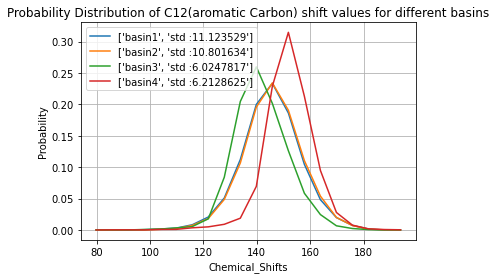

In [40]:
F = cs_data[(cs_data== 'C12').any(axis=1)]

c12_cs = F[4].to_numpy()
basin1_c12 = c12_cs[basin_1[0]].astype(np.float32)
basin2_c12 = c12_cs[basin_2[0]].astype(np.float32)
basin3_c12 = c12_cs[basin_3[0]].astype(np.float32)
basin4_c12 = c12_cs[basin_4[0]].astype(np.float32)

basin1_c12std = np.std(basin1_c12)
basin2_c12std = np.std(basin2_c12)
basin3_c12std = np.std(basin3_c12)
basin4_c12std = np.std(basin4_c12)

count1, edges1 = np.histogram(basin1_c12, bins = 20)
density_angle1 = count1 / np.sum(count1)


count2, edges2 = np.histogram(basin2_c12, bins=20)
density_angle2 = count2 / np.sum(count2)

count3, edges3 = np.histogram(basin3_c12, bins=20)
density_angle3 = count3 / np.sum(count3)

count4, edges4 = np.histogram(basin4_c12, bins=20)
density_angle4 = count4 / np.sum(count4)

plt.plot(edges1[1:], density_angle1, label=["basin1", "std :"+str(basin1_c12std)])
plt.plot(edges1[1:], density_angle2, label=["basin2", "std :"+str(basin2_c12std)])
plt.plot(edges1[1:], density_angle3, label=["basin3", "std :"+str(basin3_c12std)])
plt.plot(edges1[1:], density_angle4, label=["basin4", "std :"+str(basin4_c12std)])




plt.xlabel("Chemical_Shifts")
plt.ylabel("Probability")
plt.title("Probability Distribution of C12(aromatic Carbon) shift values for different basins")
plt.grid()
plt.legend()
plt.show()

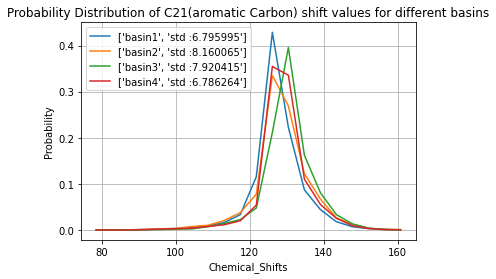

In [41]:
G = cs_data[(cs_data== 'C21').any(axis=1)]


c21_cs = G[4].to_numpy()
basin1_c21 = c21_cs[basin_1[0]].astype(np.float32)
basin2_c21 = c21_cs[basin_2[0]].astype(np.float32)
basin3_c21 = c21_cs[basin_3[0]].astype(np.float32)
basin4_c21 = c21_cs[basin_4[0]].astype(np.float32)

basin1_c21std = np.std(basin1_c21)
basin2_c21std = np.std(basin2_c21)
basin3_c21std = np.std(basin3_c21)
basin4_c21std = np.std(basin4_c21)

count1, edges1 = np.histogram(basin1_c21, bins = 20)
density_angle1 = count1 / np.sum(count1)


count2, edges2 = np.histogram(basin2_c21, bins=20)
density_angle2 = count2 / np.sum(count2)

count3, edges3 = np.histogram(basin3_c21, bins=20)
density_angle3 = count3 / np.sum(count3)

count4, edges4 = np.histogram(basin4_c21, bins=20)
density_angle4 = count4 / np.sum(count4)


plt.plot(edges1[1:], density_angle1, label=["basin1", "std :"+str(basin1_c21std)])
plt.plot(edges1[1:], density_angle2, label=["basin2", "std :"+str(basin2_c21std)])
plt.plot(edges1[1:], density_angle3, label=["basin3", "std :"+str(basin3_c21std)])
plt.plot(edges1[1:], density_angle4, label=["basin4", "std :"+str(basin4_c21std)])



plt.xlabel("Chemical_Shifts")
plt.ylabel("Probability")
plt.title("Probability Distribution of C21(aromatic Carbon) shift values for different basins")
plt.grid()
plt.legend()
plt.show()

 REWEIGHTING PORTION

In [42]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

In [43]:
def read_cs_md(data):
 confd = { 'C1': { },
          'C2' : { },
          'C3': { },
          'C4': { },
          'C5': { },
          'C6': { },
          'C7': { },
          'C8': { },
          'C9': { },
          'C10': { },
          'C11': { },
          'C12': { },
          'C13': { },
          'C14': { },
          'C15': { },
          'C16': { },
          'C17': { },
          'C18': { },
          'C19': { },
          'C20': { },
          'C21': { },
          'H1': { },
          'H2':{ },
          'H3':{ },
          'H4':{ },
          'H5':{ },
          'H6':{ },
          'H7':{ },
          'H8':{ },
          'H9':{ },
          'H10':{ },
          'H11':{ },
          'H12':{ },
          'H13':{ },
          'H14':{ },
          'H15':{ },
          'H16':{ },
          'H17':{ },
          'H18':{ },
          'H19':{ },
          'H20':{ },
          'H21':{ },
          'H22':{ },
          'H23':{ },
          'H24':{ },
          'H25':{ },
          'H26':{ },
          'H27': { }}
 for lines in open(data, "r").readlines():
        riga=lines.strip().split(",")
        #riga=lines.strip().split(" ")
        # key dictionary
        key=riga[0]
        key2=riga[1]
        confd[key2][key]=[] 
        timeseries=np.asarray(riga[2:]).astype(float)
        confd[key2][key]=timeseries
 return(confd)

def read_exp_cs(data):
 confd = { 'C1': { },
          'C2': { },
          'C3': { },
          'C4': { },
          'C5': { },
          'C6': { },
          'C7': { },
          'C8': { },
          'C9': { },
          'C10': { },
          'C11': { },
          'C12': { },
          'C13': { },
          'C14': { },
          'C15': { },
          'C16': { },
          'C17': { },
          'C18': { },
          'C19': { },
          'C20': { },
          'C21': { },
          'H1': { },
          'H2':{ },
          'H3':{ },
          'H4':{ },
          'H5':{ },
          'H6':{ },
          'H7':{ },
          'H8':{ },
          'H9':{ },
          'H10':{ },
          'H11':{ },
          'H12':{ },
          'H13':{ },
          'H14':{ },
          'H15':{ },
          'H16':{ },
          'H17':{ },
          'H18':{ },
          'H19':{ },
          'H20':{ },
          'H21':{ },
          'H22':{ },
          'H23':{ },
          'H24':{ },
          'H25':{ },
          'H26':{ },
          'H27': { }}
 for lines in open(data, "r").readlines():
        #riga=lines.strip().split(",")
        riga=lines.strip().split(" ")
        # key dictionary
        key=riga[0]
        key2=riga[1]
        confd[key2][key]=[]
        confd[key2][key] += map(float, [float(riga[2])])
 return(confd)

def add_md_data(data,dict,key):
  dict[key]={}
  for lines in open(data, "r").readlines():
        riga=lines.strip().split(",")
        #riga=lines.strip().split(" ")
        key2=riga[0]
        timeseries=np.asarray(riga[1:]).astype(float)
        dict[key][key2]=[]
        dict[key][key2]=(timeseries)
  return(dict)

def add_exp_data(data,dict,key):
  dict[key]={}
  for lines in open(data, "r").readlines():
        #riga=lines.strip().split(",")
        riga=lines.strip().split(" ")
        key2=riga[0]
        dict[key][key2]=[]
        dict[key][key2] += map(float, [float(riga[1])])
  return(dict)

In [44]:
outdir = '/home/exx/Downloads/nmrgnn/reweighting/output/'
datadir = '/home/exx/Downloads/nmrgnn/reweighting/'
expdatadir = '/home/exx/Downloads/nmrgnn/reweighting/'

if not os.path.exists(outdir):
    os.makedirs(outdir)

print("outdir",outdir)
print("datadir",datadir)
print("expdata_dir",expdatadir)

outdir /home/exx/Downloads/nmrgnn/reweighting/output/
datadir /home/exx/Downloads/nmrgnn/reweighting/
expdata_dir /home/exx/Downloads/nmrgnn/reweighting/


In [45]:
expdata=read_exp_cs(expdatadir+'/CS.exp.dat')
compdata=read_cs_md(datadir+'/chemical_shifts.all.txt')

In [46]:
Cnames = ["C{}".format(i) for i in range(1,22)]
Cnames

['C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21']

REWEIGHTING WITH ALL CARBON ATOMS:

In [71]:
#Set Data For Reweighting and Validation
Reweight_Data= ["C{}".format(i) for i in range(1,22)]
Validation_Data=['C4','C5','C7','H2']
#STRENGTH OF THE RESTRAINT
#Max+Francesco's Theta
sigma_m=float(100.0)


compare=[]
exp_r=[] 
traj_r=[]
err_r=[]
data_r_t=[]
data_r_type={}

traj_v=[]
exp_v=[]
data_v_t=[]
data_v_type={}
err_v=[]


err_d = { 'C1': 0.1,
          'C2' : 0.1,
          'C3': 0.1,
          'C4': 0.1,
          'C5': 0.1,
          'C6': 0.1,
          'C7': 0.1,
          'C8': 0.1,
          'C9': 0.1,
          'C10': 0.1,
          'C11': 0.1,
          'C12': 0.1,
          'C13': 0.1,
          'C14': 0.1,
          'C15': 0.1,
          'C16': 0.1,
          'C17': 0.1,
          'C18': 0.1,
          'C19': 0.1,
          'C20': 0.1,
          'C21': 0.1,
          'H1': 0.1,
          'H2':0.1,
          'H3':0.1,
          'H4':0.1,
          'H5':0.1,
          'H6':0.1,
          'H7':0.1,
          'H8':0.1,
          'H9':0.1,
          'H10':0.1,
          'H11':0.1,
          'H12':0.1,
          'H13':0.1,
          'H14':0.1,
          'H15':0.1,
          'H16':0.1,
          'H17':0.1,
          'H18':0.1,
          'H19':0.1,
          'H20':0.1,
          'H21':0.1,
          'H22':0.1,
          'H23':0.1,
          'H24':0.1,
          'H25':0.1,
          'H26':0.1,
          'H27': 0.1}

compare_dict_r = { 'C1': { },
          'C2': { },
          'C3': { },
          'C4': { },
          'C5': { },
          'C6': { },
          'C7': { },
          'C8': { },
          'C9': { },
          'C10': { },
          'C11': { },
          'C12': { },
          'C13': { },
          'C14': { },
          'C15': { },
          'C16': { },
          'C17': { },
          'C18': { },
          'C19': { },
          'C20': { },
          'C21': { },
          'H1': { },
          'H2':{ },
          'H3':{ },
          'H4':{ },
          'H5':{ },
          'H6':{ },
          'H7':{ },
          'H8':{ },
          'H9':{ },
          'H10':{ },
          'H11':{ },
          'H12':{ },
          'H13':{ },
          'H14':{ },
          'H15':{ },
          'H16':{ },
          'H17':{ },
          'H18':{ },
          'H19':{ },
          'H20':{ },
          'H21':{ },
          'H22':{ },
          'H23':{ },
          'H24':{ },
          'H25':{ },
          'H26':{ },
          'H27': { }}

compare_dict_v = { 'C1': { },
          'C2': { },
          'C3': { },
          'C4': { },
          'C5': { },
          'C6': { },
          'C7': { },
          'C8': { },
          'C9': { },
          'C10': { },
          'C11': { },
          'C12': { },
          'C13': { },
          'C14': { },
          'C15': { },
          'C16': { },
          'C17': { },
          'C18': { },
          'C19': { },
          'C20': { },
          'C21': { },
          'H1': { },
          'H2':{ },
          'H3':{ },
          'H4':{ },
          'H5':{ },
          'H6':{ },
          'H7':{ },
          'H8':{ },
          'H9':{ },
          'H10':{ },
          'H11':{ },
          'H12':{ },
          'H13':{ },
          'H14':{ },
          'H15':{ },
          'H16':{ },
          'H17':{ },
          'H18':{ },
          'H19':{ },
          'H20':{ },
          'H21':{ },
          'H22':{ },
          'H23':{ },
          'H24':{ },
          'H25':{ },
          'H26':{ },
          'H27': { }}

#Process Reweight data into arrays
for key in Reweight_Data:   
 for key2 in expdata[key]:
  #print(key,key2,expdata[key][key2][0])
  #Check if Experimental Value is 0, if not retrieve the MD timeseries 
  if expdata[key][key2][0]!=0:  
   if key2 in compdata[key]:
    if compdata[key][key2][0]!=0:
     compare_dict_r[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
     traj_r.append(compdata[key][key2])
     exp_r.append(expdata[key][key2][0])
     err_r.append(err_d[key]) 
     data_r_t.append(str(key))

for key in Reweight_Data: 
   data_id=np.zeros(len(data_r_t)) 
   for i, id in enumerate(data_r_t): 
     if id==str(key):
      data_id[i]=float(1)
   data_r_type[key]=data_id 

#Process Validation data into arrays
for key in Validation_Data:   
 for key2 in expdata[key]:
  if expdata[key][key2][0]!=0:
   if key2 in compdata[key]:
    if compdata[key][key2][0]!=0:
    #This is a hack so it doesn't choke for non-residue specific data read in as an array
    #if np.average(compdata[key][key2][0])!=0:
     compare_dict_v[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
     traj_v.append(compdata[key][key2])
     exp_v.append(expdata[key][key2][0])
     err_v.append(err_d[key]) 
     data_v_t.append(str(key))

for key in Validation_Data: 
   data_id=np.zeros(len(data_v_t)) 
   for i, id in enumerate(data_v_t): 
     if id==str(key):
      data_id[i]=float(1)
   data_v_type[key]=data_id 

In [72]:
traj_r=np.asarray(traj_r)
traj_v=np.asarray(traj_v)
# experimental data for reweighting - 1 column per exp data - 1 row
obs_exp_r=np.asarray(exp_r)
obs_exp_v=np.asarray(exp_v)
# predictor/experimental errors for reweighting - 1 column per exp data - 1 row
err_r=np.asarray(err_r)
err_v=np.asarray(err_v)

#Uniform Initial Weights For Each Frame
weight_bias=np.ones(len(traj_r[0]))
#sigma_m=float(0.1)
# calculate sigma vector
sigma=sigma_m*err_r
#print(sigma)
#number of observables
nobs_r=len(sigma)
nobs_v=len(obs_exp_v)
#number of frames
nframes=len(traj_r[0])

print('# of Frames:',nframes)
#log.write('# of Frames:%s'%nframes+"\n")

print('Reweight Data Points:',nobs_r)
#log.write('Reweight Data Points: %s'%nobs_r+"\n")

for key in data_r_type:
    print(str(key)+':',sum(data_r_type[key]))
    #log.write(str(key)+': %s'%sum(data_r_type[key])+"\n")
    
print('Validation Data Points:',nobs_v)
#log.write('Validation Data Points: %s'%nobs_v+"\n")
for key in data_v_type:
    print(str(key)+':',sum(data_v_type[key]))

# of Frames: 55157
Reweight Data Points: 21
C1: 1.0
C2: 1.0
C3: 1.0
C4: 1.0
C5: 1.0
C6: 1.0
C7: 1.0
C8: 1.0
C9: 1.0
C10: 1.0
C11: 1.0
C12: 1.0
C13: 1.0
C14: 1.0
C15: 1.0
C16: 1.0
C17: 1.0
C18: 1.0
C19: 1.0
C20: 1.0
C21: 1.0
Validation Data Points: 4
C4: 1.0
C5: 1.0
C7: 1.0
H2: 1.0


In [73]:
# maxent calculation

# function to be minimized:
# attention: it reads global variables weight_bias, obs_exp, and sigma
def func(l):
    l = np.array(l) # ensure array
    weight_all = +weight_bias # copy
    weight_all -= np.dot(l,traj_r) # maxent correction
    shift_all = np.max(weight_all) # shift to avoid overflow
    weight_all = np.exp(weight_all - shift_all) # compute weights

    # same stuff with original ensemble
    weight_0 = +weight_bias # copy
    shift_0 = np.max(weight_0) # shift to avoid overflow
    weight_0 = np.exp(weight_0 - shift_0) # compute weights

    # Gamma function in maxent:
    #Shifts to avoid overflows
    f = np.log(np.sum(weight_all) / np.sum(weight_0)) + shift_all - shift_0 + np.dot(l,obs_exp_r)

    # derivative of Gamma function:
    der = obs_exp_r - np.dot(traj_r,weight_all) / np.sum(weight_all) # derivative with respect to l

    # regularization term
    # REGULARIZE
    f += 0.5*np.sum(sigma*l**2)
    der += sigma*l

    return(f,der)

In [74]:
# perform minimization
#res.X lagrange multiplier
#res = sp.optimize.minimize(func, np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
import scipy as sp
res = sp.optimize.minimize(func, np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)


# ANALYSIS
# calculate normalized initial weights
initial_weights=weight_bias
initial_weights-=np.max(initial_weights)
initial_weights=np.exp(initial_weights)
initial_weights/=np.sum(initial_weights)
# initial average observables for reweighting and validation
initial_obs_r=np.dot(traj_r,initial_weights)
initial_obs_v=np.dot(traj_v,initial_weights)

# various initial RMSE
print("Initial RMSE reweight data ")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
      calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q scaled:", end = '')
      print(" %6.3lf" % qf)

print("Initial RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end= '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
      calc_rdc=np.trim_zeros(initial_obs_v*data_v_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

    
print("minimization worked:",res.success)
#print("lagrangian multipliers:",res.x)
# calculate normalized final weights
final_weights=(weight_bias-np.dot(res.x,traj_r))
final_weights-=np.max(final_weights)
final_weights=np.exp(final_weights)
final_weights/=np.sum(final_weights)
# final average observables for reweighting and validation
final_obs_r=np.dot(traj_r,final_weights)
final_obs_v=np.dot(traj_v,final_weights)
# various final RMSE
print("Final RMSE reweight data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
      calc_rdc=np.trim_zeros(final_obs_r*data_r_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

print("Final RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
      calc_rdc=np.trim_zeros(final_obs_v*data_v_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

    
# Kish effective size
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
print("Kish ratio : %9.6lf" % (Ks_a/Ks_b*100.0))

np.savetxt('%s/weights_final.dat'%(outdir),final_weights,fmt=" %6.12lf")
# print final weights to file
f=open("%s/weights_final.a.dat"%outdir, "w")
for w in final_weights:
    f.write("%e\n" % w)
f.close()

Initial RMSE reweight data 
 * Total :      0.979
 *    C1 :      0.112
 *    C2 :      0.892
 *    C3 :      0.452
 *    C4 :      2.385
 *    C5 :      0.397
 *    C6 :      0.617
 *    C7 :      0.128
 *    C8 :      0.050
 *    C9 :      0.045
 *    C10 :      0.041
 *    C11 :      0.603
 *    C12 :      3.425
 *    C13 :      0.051
 *    C14 :      0.289
 *    C15 :      0.243
 *    C16 :      0.132
 *    C17 :      0.194
 *    C18 :      0.633
 *    C19 :      0.340
 *    C20 :      0.197
 *    C21 :      0.136
Initial RMSE validation data
 * Total :      1.211
 *    C4 :      2.385
 *    C5 :      0.397
 *    C7 :      0.128
 *    H2 :      0.050
minimization worked: True
Final RMSE reweight data
 * Total :      0.137
 *    C1 :      0.045
 *    C2 :      0.236
 *    C3 :      0.003
 *    C4 :      0.331
 *    C5 :      0.016
 *    C6 :      0.009
 *    C7 :      0.017
 *    C8 :      0.037
 *    C9 :      0.031
 *    C10 :      0.028
 *    C11 :      0.031
 *    C12 :      0.4

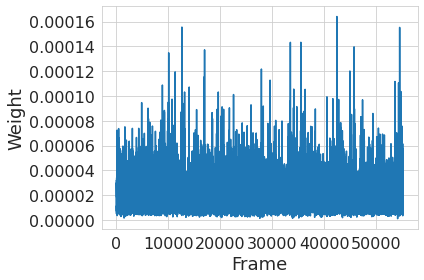

In [75]:
plt.plot(final_weights)
plt.ylabel('Weight',size=18)
plt.xlabel('Frame',size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='16')
plt.yticks(size='16')
plt.tight_layout()
plt.savefig('%s/FrameWeights.png'%outdir)
plt.show()

In [76]:
exp=[]
calc=[]
rmsdin = []
rmsdf = []
for t in Reweight_Data:
 if t!='Rg':
  print(t)
  resid=[]
    
  err_fit=[]    
  err=err_d[t]
  for i,id in enumerate(compare_dict_r[t]): 
   resid.append(float(id))
   #exp.append(compare_dict_r[t][id][0]) 
   #err_fit.append(err)
  initial=np.trim_zeros(initial_obs_r*data_r_type[t])
  reweight=np.trim_zeros(final_obs_r*data_r_type[t])
  exp=np.trim_zeros(obs_exp_r*data_r_type[t])
  err=err_d[t]
  rmsd_i=(sum(np.square(initial-exp))/len(exp))**0.5
  rmsd_f=(sum(np.square(reweight-exp))/len(exp))**0.5
  print("RMSD_initial:%6.3lf" %rmsd_i,"RMSD_final:%6.3lf"%rmsd_f)
  rmsdin.append(rmsd_i)
  rmsdf.append(rmsd_f) 

C1
RMSD_initial: 0.112 RMSD_final: 0.045
C2
RMSD_initial: 0.892 RMSD_final: 0.236
C3
RMSD_initial: 0.452 RMSD_final: 0.003
C4
RMSD_initial: 2.385 RMSD_final: 0.331
C5
RMSD_initial: 0.397 RMSD_final: 0.016
C6
RMSD_initial: 0.617 RMSD_final: 0.009
C7
RMSD_initial: 0.128 RMSD_final: 0.017
C8
RMSD_initial: 0.050 RMSD_final: 0.037
C9
RMSD_initial: 0.045 RMSD_final: 0.031
C10
RMSD_initial: 0.041 RMSD_final: 0.028
C11
RMSD_initial: 0.603 RMSD_final: 0.031
C12
RMSD_initial: 3.425 RMSD_final: 0.408
C13
RMSD_initial: 0.051 RMSD_final: 0.017
C14
RMSD_initial: 0.289 RMSD_final: 0.054
C15
RMSD_initial: 0.243 RMSD_final: 0.154
C16
RMSD_initial: 0.132 RMSD_final: 0.087
C17
RMSD_initial: 0.194 RMSD_final: 0.007
C18
RMSD_initial: 0.633 RMSD_final: 0.034
C19
RMSD_initial: 0.340 RMSD_final: 0.007
C20
RMSD_initial: 0.197 RMSD_final: 0.135
C21
RMSD_initial: 0.136 RMSD_final: 0.034


In [77]:
rmsdin_arr = np.asarray(rmsdin)
rmsdf_arr = np.asarray(rmsdf)
av_rmsdin = np.average(rmsdin_arr)
av_rmsdf = np.average(rmsdf_arr)
print(av_rmsdin, av_rmsdf)

0.5410907867864121 0.08195092979120844


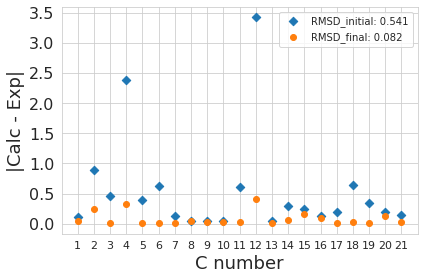

In [78]:
rlist = [i for i in range(1,22)]
plt.scatter(rlist, rmsdin, marker = 'D', label="RMSD_initial:%6.3lf"%av_rmsdin)
plt.scatter(rlist, rmsdf, marker = 'o', label= "RMSD_final:%6.3lf"%av_rmsdf)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xticks(rlist)
plt.ylabel('|Calc - Exp|',size=18)
plt.xticks(fontsize=11)
plt.yticks(fontsize=16)
plt.xlabel('C number',size=18)
plt.legend(loc='upper right')
plt.tight_layout() 

REWEIGHTING WITH AROMATIC CARBONS

In [79]:
#Set Data For Reweighting and Validation
Reweight_Data= ['C3', 'C4', 'C5', 'C6', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C20', 'C21']
#Reweight_Data=['CA','CB','H','N','HA','Rg']
Validation_Data=['C4','C5','C7','H2']
#STRENGTH OF THE RESTRAINT
#Max+Francesco's Theta
sigma_m=float(100.0)


compare=[]
exp_r=[] 
traj_r=[]
err_r=[]
data_r_t=[]
data_r_type={}

traj_v=[]
exp_v=[]
data_v_t=[]
data_v_type={}
err_v=[]


err_d = { 'C1': 0.1,
          'C2' : 0.1,
          'C3': 0.1,
          'C4': 0.1,
          'C5': 0.1,
          'C6': 0.1,
          'C7': 0.1,
          'C8': 0.1,
          'C9': 0.1,
          'C10': 0.1,
          'C11': 0.1,
          'C12': 0.1,
          'C13': 0.1,
          'C14': 0.1,
          'C15': 0.1,
          'C16': 0.1,
          'C17': 0.1,
          'C18': 0.1,
          'C19': 0.1,
          'C20': 0.1,
          'C21': 0.1,
          'H1': 0.1,
          'H2':0.1,
          'H3':0.1,
          'H4':0.1,
          'H5':0.1,
          'H6':0.1,
          'H7':0.1,
          'H8':0.1,
          'H9':0.1,
          'H10':0.1,
          'H11':0.1,
          'H12':0.1,
          'H13':0.1,
          'H14':0.1,
          'H15':0.1,
          'H16':0.1,
          'H17':0.1,
          'H18':0.1,
          'H19':0.1,
          'H20':0.1,
          'H21':0.1,
          'H22':0.1,
          'H23':0.1,
          'H24':0.1,
          'H25':0.1,
          'H26':0.1,
          'H27': 0.1}

compare_dict_r = { 'C1': { },
          'C2': { },
          'C3': { },
          'C4': { },
          'C5': { },
          'C6': { },
          'C7': { },
          'C8': { },
          'C9': { },
          'C10': { },
          'C11': { },
          'C12': { },
          'C13': { },
          'C14': { },
          'C15': { },
          'C16': { },
          'C17': { },
          'C18': { },
          'C19': { },
          'C20': { },
          'C21': { },
          'H1': { },
          'H2':{ },
          'H3':{ },
          'H4':{ },
          'H5':{ },
          'H6':{ },
          'H7':{ },
          'H8':{ },
          'H9':{ },
          'H10':{ },
          'H11':{ },
          'H12':{ },
          'H13':{ },
          'H14':{ },
          'H15':{ },
          'H16':{ },
          'H17':{ },
          'H18':{ },
          'H19':{ },
          'H20':{ },
          'H21':{ },
          'H22':{ },
          'H23':{ },
          'H24':{ },
          'H25':{ },
          'H26':{ },
          'H27': { }}

compare_dict_v = { 'C1': { },
          'C2': { },
          'C3': { },
          'C4': { },
          'C5': { },
          'C6': { },
          'C7': { },
          'C8': { },
          'C9': { },
          'C10': { },
          'C11': { },
          'C12': { },
          'C13': { },
          'C14': { },
          'C15': { },
          'C16': { },
          'C17': { },
          'C18': { },
          'C19': { },
          'C20': { },
          'C21': { },
          'H1': { },
          'H2':{ },
          'H3':{ },
          'H4':{ },
          'H5':{ },
          'H6':{ },
          'H7':{ },
          'H8':{ },
          'H9':{ },
          'H10':{ },
          'H11':{ },
          'H12':{ },
          'H13':{ },
          'H14':{ },
          'H15':{ },
          'H16':{ },
          'H17':{ },
          'H18':{ },
          'H19':{ },
          'H20':{ },
          'H21':{ },
          'H22':{ },
          'H23':{ },
          'H24':{ },
          'H25':{ },
          'H26':{ },
          'H27': { }}

#Process Reweight data into arrays
for key in Reweight_Data:   
 for key2 in expdata[key]:
  #print(key,key2,expdata[key][key2][0])
  #Check if Experimental Value is 0, if not retrieve the MD timeseries 
  if expdata[key][key2][0]!=0:  
   if key2 in compdata[key]:
    if compdata[key][key2][0]!=0:
     compare_dict_r[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
     traj_r.append(compdata[key][key2])
     exp_r.append(expdata[key][key2][0])
     err_r.append(err_d[key]) 
     data_r_t.append(str(key))

for key in Reweight_Data: 
   data_id=np.zeros(len(data_r_t)) 
   for i, id in enumerate(data_r_t): 
     if id==str(key):
      data_id[i]=float(1)
   data_r_type[key]=data_id 

#Process Validation data into arrays
for key in Validation_Data:   
 for key2 in expdata[key]:
  if expdata[key][key2][0]!=0:
   if key2 in compdata[key]:
    if compdata[key][key2][0]!=0:
    #This is a hack so it doesn't choke for non-residue specific data read in as an array
    #if np.average(compdata[key][key2][0])!=0:
     compare_dict_v[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
     traj_v.append(compdata[key][key2])
     exp_v.append(expdata[key][key2][0])
     err_v.append(err_d[key]) 
     data_v_t.append(str(key))

for key in Validation_Data: 
   data_id=np.zeros(len(data_v_t)) 
   for i, id in enumerate(data_v_t): 
     if id==str(key):
      data_id[i]=float(1)
   data_v_type[key]=data_id 

In [80]:
traj_r=np.asarray(traj_r)
traj_v=np.asarray(traj_v)
# experimental data for reweighting - 1 column per exp data - 1 row
obs_exp_r=np.asarray(exp_r)
obs_exp_v=np.asarray(exp_v)
# predictor/experimental errors for reweighting - 1 column per exp data - 1 row
err_r=np.asarray(err_r)
err_v=np.asarray(err_v)

#Uniform Initial Weights For Each Frame
weight_bias=np.ones(len(traj_r[0]))
#sigma_m=float(0.1)
# calculate sigma vector
sigma=sigma_m*err_r
#number of observables
nobs_r=len(sigma)
nobs_v=len(obs_exp_v)
#number of frames
nframes=len(traj_r[0])

print('# of Frames:',nframes)


print('Reweight Data Points:',nobs_r)


for key in data_r_type:
    print(str(key)+':',sum(data_r_type[key]))
    
    
print('Validation Data Points:',nobs_v)

for key in data_v_type:
    print(str(key)+':',sum(data_v_type[key]))

# of Frames: 55157
Reweight Data Points: 12
C3: 1.0
C4: 1.0
C5: 1.0
C6: 1.0
C11: 1.0
C12: 1.0
C13: 1.0
C14: 1.0
C15: 1.0
C16: 1.0
C20: 1.0
C21: 1.0
Validation Data Points: 4
C4: 1.0
C5: 1.0
C7: 1.0
H2: 1.0


In [81]:
# maxent calculation

# function to be minimized:
# attention: it reads global variables weight_bias, obs_exp, and sigma
def func(l):
    l = np.array(l) # ensure array
    weight_all = +weight_bias # copy
    weight_all -= np.dot(l,traj_r) # maxent correction
    shift_all = np.max(weight_all) # shift to avoid overflow
    weight_all = np.exp(weight_all - shift_all) # compute weights

    # same stuff with original ensemble
    weight_0 = +weight_bias # copy
    shift_0 = np.max(weight_0) # shift to avoid overflow
    weight_0 = np.exp(weight_0 - shift_0) # compute weights

    # Gamma function in maxent:
    #Shifts to avoid overflows
    f = np.log(np.sum(weight_all) / np.sum(weight_0)) + shift_all - shift_0 + np.dot(l,obs_exp_r)

    # derivative of Gamma function:
    der = obs_exp_r - np.dot(traj_r,weight_all) / np.sum(weight_all) # derivative with respect to l

    # regularization term
    # REGULARIZE
    f += 0.5*np.sum(sigma*l**2)
    der += sigma*l

    return(f,der)

In [82]:
# perform minimization
#res.X lagrange multiplier
#res = sp.optimize.minimize(func, np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
res = sp.optimize.minimize(func, np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)


# ANALYSIS
# calculate normalized initial weights
initial_weights=weight_bias
initial_weights-=np.max(initial_weights)
initial_weights=np.exp(initial_weights)
initial_weights/=np.sum(initial_weights)
# initial average observables for reweighting and validation
initial_obs_r=np.dot(traj_r,initial_weights)
initial_obs_v=np.dot(traj_v,initial_weights)

# various initial RMSE
print("Initial RMSE reweight data ")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
      calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q scaled:", end = '')
      print(" %6.3lf" % qf)

print("Initial RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end= '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
      calc_rdc=np.trim_zeros(initial_obs_v*data_v_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

    
print("minimization worked:",res.success)
#print("lagrangian multipliers:",res.x)
# calculate normalized final weights
final_weights=(weight_bias-np.dot(res.x,traj_r))
final_weights-=np.max(final_weights)
final_weights=np.exp(final_weights)
final_weights/=np.sum(final_weights)
# final average observables for reweighting and validation
final_obs_r=np.dot(traj_r,final_weights)
final_obs_v=np.dot(traj_v,final_weights)
# various final RMSE
print("Final RMSE reweight data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
      calc_rdc=np.trim_zeros(final_obs_r*data_r_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

print("Final RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
      calc_rdc=np.trim_zeros(final_obs_v*data_v_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

    
# Kish effective size
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
print("Kish ratio : %9.6lf" % (Ks_a/Ks_b*100.0))

np.savetxt('%s/weights_final_1.dat'%(outdir),final_weights,fmt=" %6.12lf")
# print final weights to file
f=open("%s/weights_final.a.dat"%outdir, "w")
for w in final_weights:
    f.write("%e\n" % w)
f.close()

Initial RMSE reweight data 
 * Total :      1.250
 *    C3 :      0.452
 *    C4 :      2.385
 *    C5 :      0.397
 *    C6 :      0.617
 *    C11 :      0.603
 *    C12 :      3.425
 *    C13 :      0.051
 *    C14 :      0.289
 *    C15 :      0.243
 *    C16 :      0.132
 *    C20 :      0.197
 *    C21 :      0.136
Initial RMSE validation data
 * Total :      1.211
 *    C4 :      2.385
 *    C5 :      0.397
 *    C7 :      0.128
 *    H2 :      0.050
minimization worked: True
Final RMSE reweight data
 * Total :      0.165
 *    C3 :      0.004
 *    C4 :      0.331
 *    C5 :      0.015
 *    C6 :      0.013
 *    C11 :      0.033
 *    C12 :      0.404
 *    C13 :      0.003
 *    C14 :      0.041
 *    C15 :      0.142
 *    C16 :      0.092
 *    C20 :      0.148
 *    C21 :      0.021
Final RMSE validation data
 * Total :      0.218
 *    C4 :      0.331
 *    C5 :      0.015
 *    C7 :      0.278
 *    H2 :      0.048
Initial Kish size :  1.000000 55157
Reweighted Kish size 

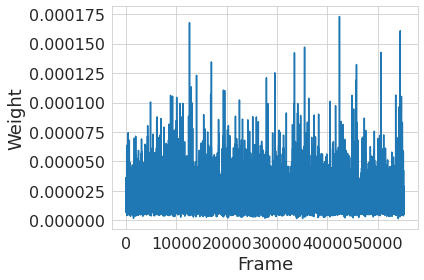

In [83]:
plt.plot(final_weights)
plt.ylabel('Weight',size=18)
plt.xlabel('Frame',size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='16')
plt.yticks(size='16')
plt.tight_layout()
plt.savefig('%s/FrameWeights.png'%outdir)
plt.show()

In [84]:
exp=[]
calc=[]
rmsdin = []
rmsdf = []
for t in Reweight_Data:
 if t!='Rg':
  print(t)
  resid=[]
    
  err_fit=[]    
  err=err_d[t]
  for i,id in enumerate(compare_dict_r[t]): 
   resid.append(float(id))
   #exp.append(compare_dict_r[t][id][0]) 
   #err_fit.append(err)
  initial=np.trim_zeros(initial_obs_r*data_r_type[t])
  reweight=np.trim_zeros(final_obs_r*data_r_type[t])
  exp=np.trim_zeros(obs_exp_r*data_r_type[t])
  err=err_d[t]
  rmsd_i=(sum(np.square(initial-exp))/len(exp))**0.5
  rmsd_f=(sum(np.square(reweight-exp))/len(exp))**0.5
  print("RMSD_initial:%6.3lf" %rmsd_i,"RMSD_final:%6.3lf"%rmsd_f)
  rmsdin.append(rmsd_i)
  rmsdf.append(rmsd_f) 

C3
RMSD_initial: 0.452 RMSD_final: 0.004
C4
RMSD_initial: 2.385 RMSD_final: 0.331
C5
RMSD_initial: 0.397 RMSD_final: 0.015
C6
RMSD_initial: 0.617 RMSD_final: 0.013
C11
RMSD_initial: 0.603 RMSD_final: 0.033
C12
RMSD_initial: 3.425 RMSD_final: 0.404
C13
RMSD_initial: 0.051 RMSD_final: 0.003
C14
RMSD_initial: 0.289 RMSD_final: 0.041
C15
RMSD_initial: 0.243 RMSD_final: 0.142
C16
RMSD_initial: 0.132 RMSD_final: 0.092
C20
RMSD_initial: 0.197 RMSD_final: 0.148
C21
RMSD_initial: 0.136 RMSD_final: 0.021


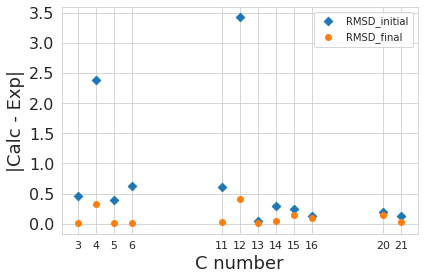

In [91]:
listarom = [3,4,5,6,11,12,13,14,15,16,20,21]
plt.scatter(rlist, rmsdin, marker = 'D', label="RMSD_initial")
plt.scatter(rlist, rmsdf, marker = 'o', label= "RMSD_final")
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xticks(rlist)
plt.ylabel('|Calc - Exp|',size=18)
plt.xticks(fontsize=11)
plt.yticks(fontsize=16)
plt.xlabel('C number',size=18)
plt.legend(loc='upper right')
plt.tight_layout()

In [92]:
#Plot Fitting Data
initialdata =[]
reweightdata = []

calc=[]    
err_fit=[]    
err=err_d[t]
for t in Reweight_Data:
 if t!='Rg':
  #print(t)
  resid=[]
  exp=[]
  for i,id in enumerate(compare_dict_r[t]): 
   resid.append(float(id))
   exp.append(compare_dict_r[t][id][0]) 
   err_fit.append(err)
  initial=np.trim_zeros(initial_obs_r*data_r_type[t])
  reweight=np.trim_zeros(final_obs_r*data_r_type[t])
  initialdata.append(initial)
  reweightdata.append(reweight)

In [93]:
rewtlist = ["C{}".format(i) for i in listarom]
explist = [expdata[key]["1.0"] for key in rewtlist]

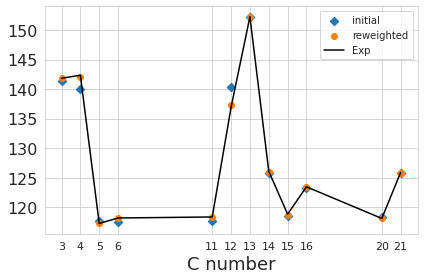

In [98]:
listarom = [3,4,5,6,11,12,13,14,15,16,20,21]
plt.scatter(listarom, initialdata, marker = 'D', label="initial")
plt.scatter(listarom, reweightdata, marker = 'o', label= "reweighted")
plt.plot(listarom, explist, label='Exp', color="black")
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xticks(listarom)
plt.xticks(fontsize=11)
plt.yticks(fontsize=16)
plt.xlabel('C number',size=18)
plt.legend(loc='upper right')
plt.tight_layout() 

REWEIGHTING WITH SCAFFOLD ALIPHATIC CARBONS

In [99]:
scaflist = [7,8,9,10,17,18]
#Set Data For Reweighting and Validation
Reweight_Data= ["C{}".format(i) for i in scaflist]
Validation_Data=['C4','C5','C7','H2']
#STRENGTH OF THE RESTRAINT
#Max+Francesco's Theta
sigma_m=float(100.0)


compare=[]
exp_r=[] 
traj_r=[]
err_r=[]
data_r_t=[]
data_r_type={}

traj_v=[]
exp_v=[]
data_v_t=[]
data_v_type={}
err_v=[]


err_d = { 'C1': 0.1,
          'C2' : 0.1,
          'C3': 0.1,
          'C4': 0.1,
          'C5': 0.1,
          'C6': 0.1,
          'C7': 0.1,
          'C8': 0.1,
          'C9': 0.1,
          'C10': 0.1,
          'C11': 0.1,
          'C12': 0.1,
          'C13': 0.1,
          'C14': 0.1,
          'C15': 0.1,
          'C16': 0.1,
          'C17': 0.1,
          'C18': 0.1,
          'C19': 0.1,
          'C20': 0.1,
          'C21': 0.1,
          'H1': 0.1,
          'H2':0.1,
          'H3':0.1,
          'H4':0.1,
          'H5':0.1,
          'H6':0.1,
          'H7':0.1,
          'H8':0.1,
          'H9':0.1,
          'H10':0.1,
          'H11':0.1,
          'H12':0.1,
          'H13':0.1,
          'H14':0.1,
          'H15':0.1,
          'H16':0.1,
          'H17':0.1,
          'H18':0.1,
          'H19':0.1,
          'H20':0.1,
          'H21':0.1,
          'H22':0.1,
          'H23':0.1,
          'H24':0.1,
          'H25':0.1,
          'H26':0.1,
          'H27': 0.1}

compare_dict_r = { 'C1': { },
          'C2': { },
          'C3': { },
          'C4': { },
          'C5': { },
          'C6': { },
          'C7': { },
          'C8': { },
          'C9': { },
          'C10': { },
          'C11': { },
          'C12': { },
          'C13': { },
          'C14': { },
          'C15': { },
          'C16': { },
          'C17': { },
          'C18': { },
          'C19': { },
          'C20': { },
          'C21': { },
          'H1': { },
          'H2':{ },
          'H3':{ },
          'H4':{ },
          'H5':{ },
          'H6':{ },
          'H7':{ },
          'H8':{ },
          'H9':{ },
          'H10':{ },
          'H11':{ },
          'H12':{ },
          'H13':{ },
          'H14':{ },
          'H15':{ },
          'H16':{ },
          'H17':{ },
          'H18':{ },
          'H19':{ },
          'H20':{ },
          'H21':{ },
          'H22':{ },
          'H23':{ },
          'H24':{ },
          'H25':{ },
          'H26':{ },
          'H27': { }}

compare_dict_v = { 'C1': { },
          'C2': { },
          'C3': { },
          'C4': { },
          'C5': { },
          'C6': { },
          'C7': { },
          'C8': { },
          'C9': { },
          'C10': { },
          'C11': { },
          'C12': { },
          'C13': { },
          'C14': { },
          'C15': { },
          'C16': { },
          'C17': { },
          'C18': { },
          'C19': { },
          'C20': { },
          'C21': { },
          'H1': { },
          'H2':{ },
          'H3':{ },
          'H4':{ },
          'H5':{ },
          'H6':{ },
          'H7':{ },
          'H8':{ },
          'H9':{ },
          'H10':{ },
          'H11':{ },
          'H12':{ },
          'H13':{ },
          'H14':{ },
          'H15':{ },
          'H16':{ },
          'H17':{ },
          'H18':{ },
          'H19':{ },
          'H20':{ },
          'H21':{ },
          'H22':{ },
          'H23':{ },
          'H24':{ },
          'H25':{ },
          'H26':{ },
          'H27': { }}

#Process Reweight data into arrays
for key in Reweight_Data:   
 for key2 in expdata[key]:
  #print(key,key2,expdata[key][key2][0])
  #Check if Experimental Value is 0, if not retrieve the MD timeseries 
  if expdata[key][key2][0]!=0:  
   if key2 in compdata[key]:
    if compdata[key][key2][0]!=0:
     compare_dict_r[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
     traj_r.append(compdata[key][key2])
     exp_r.append(expdata[key][key2][0])
     err_r.append(err_d[key]) 
     data_r_t.append(str(key))

for key in Reweight_Data: 
   data_id=np.zeros(len(data_r_t)) 
   for i, id in enumerate(data_r_t): 
     if id==str(key):
      data_id[i]=float(1)
   data_r_type[key]=data_id 

#Process Validation data into arrays
for key in Validation_Data:   
 for key2 in expdata[key]:
  if expdata[key][key2][0]!=0:
   if key2 in compdata[key]:
    if compdata[key][key2][0]!=0:
    #This is a hack so it doesn't choke for non-residue specific data read in as an array
    #if np.average(compdata[key][key2][0])!=0:
     compare_dict_v[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
     traj_v.append(compdata[key][key2])
     exp_v.append(expdata[key][key2][0])
     err_v.append(err_d[key]) 
     data_v_t.append(str(key))

for key in Validation_Data: 
   data_id=np.zeros(len(data_v_t)) 
   for i, id in enumerate(data_v_t): 
     if id==str(key):
      data_id[i]=float(1)
   data_v_type[key]=data_id 

In [100]:
traj_r=np.asarray(traj_r)
traj_v=np.asarray(traj_v)
# experimental data for reweighting - 1 column per exp data - 1 row
obs_exp_r=np.asarray(exp_r)
obs_exp_v=np.asarray(exp_v)
# predictor/experimental errors for reweighting - 1 column per exp data - 1 row
err_r=np.asarray(err_r)
err_v=np.asarray(err_v)

#Uniform Initial Weights For Each Frame
weight_bias=np.ones(len(traj_r[0]))
#sigma_m=float(0.1)
# calculate sigma vector
sigma=sigma_m*err_r
#number of observables
nobs_r=len(sigma)
nobs_v=len(obs_exp_v)
#number of frames
nframes=len(traj_r[0])

print('# of Frames:',nframes)


print('Reweight Data Points:',nobs_r)


for key in data_r_type:
    print(str(key)+':',sum(data_r_type[key]))
    
    
print('Validation Data Points:',nobs_v)

for key in data_v_type:
    print(str(key)+':',sum(data_v_type[key]))

# of Frames: 55157
Reweight Data Points: 6
C7: 1.0
C8: 1.0
C9: 1.0
C10: 1.0
C17: 1.0
C18: 1.0
Validation Data Points: 4
C4: 1.0
C5: 1.0
C7: 1.0
H2: 1.0


In [101]:
# maxent calculation

# function to be minimized:
# attention: it reads global variables weight_bias, obs_exp, and sigma
def func(l):
    l = np.array(l) # ensure array
    weight_all = +weight_bias # copy
    weight_all -= np.dot(l,traj_r) # maxent correction
    shift_all = np.max(weight_all) # shift to avoid overflow
    weight_all = np.exp(weight_all - shift_all) # compute weights

    # same stuff with original ensemble
    weight_0 = +weight_bias # copy
    shift_0 = np.max(weight_0) # shift to avoid overflow
    weight_0 = np.exp(weight_0 - shift_0) # compute weights

    # Gamma function in maxent:
    #Shifts to avoid overflows
    f = np.log(np.sum(weight_all) / np.sum(weight_0)) + shift_all - shift_0 + np.dot(l,obs_exp_r)

    # derivative of Gamma function:
    der = obs_exp_r - np.dot(traj_r,weight_all) / np.sum(weight_all) # derivative with respect to l

    # regularization term
    # REGULARIZE
    f += 0.5*np.sum(sigma*l**2)
    der += sigma*l

    return(f,der)

In [102]:
# perform minimization
#res.X lagrange multiplier
#res = sp.optimize.minimize(func, np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
res = sp.optimize.minimize(func, np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)


# ANALYSIS
# calculate normalized initial weights
initial_weights=weight_bias
initial_weights-=np.max(initial_weights)
initial_weights=np.exp(initial_weights)
initial_weights/=np.sum(initial_weights)
# initial average observables for reweighting and validation
initial_obs_r=np.dot(traj_r,initial_weights)
initial_obs_v=np.dot(traj_v,initial_weights)

# various initial RMSE
print("Initial RMSE reweight data ")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
      calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q scaled:", end = '')
      print(" %6.3lf" % qf)

print("Initial RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end= '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
      calc_rdc=np.trim_zeros(initial_obs_v*data_v_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

    
print("minimization worked:",res.success)
#print("lagrangian multipliers:",res.x)
# calculate normalized final weights
final_weights=(weight_bias-np.dot(res.x,traj_r))
final_weights-=np.max(final_weights)
final_weights=np.exp(final_weights)
final_weights/=np.sum(final_weights)
# final average observables for reweighting and validation
final_obs_r=np.dot(traj_r,final_weights)
final_obs_v=np.dot(traj_v,final_weights)
# various final RMSE
print("Final RMSE reweight data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
      calc_rdc=np.trim_zeros(final_obs_r*data_r_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

print("Final RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
      calc_rdc=np.trim_zeros(final_obs_v*data_v_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

    
# Kish effective size
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
print("Kish ratio : %9.6lf" % (Ks_a/Ks_b*100.0))

np.savetxt('%s/weights_final_2.dat'%(outdir),final_weights,fmt=" %6.12lf")
# print final weights to file
f=open("%s/weights_final.a.dat"%outdir, "w")
for w in final_weights:
    f.write("%e\n" % w)
f.close()

Initial RMSE reweight data 
 * Total :      0.277
 *    C7 :      0.128
 *    C8 :      0.050
 *    C9 :      0.045
 *    C10 :      0.041
 *    C17 :      0.194
 *    C18 :      0.633
Initial RMSE validation data
 * Total :      1.211
 *    C4 :      2.385
 *    C5 :      0.397
 *    C7 :      0.128
 *    H2 :      0.050
minimization worked: True
Final RMSE reweight data
 * Total :      0.025
 *    C7 :      0.010
 *    C8 :      0.030
 *    C9 :      0.025
 *    C10 :      0.023
 *    C17 :      0.013
 *    C18 :      0.040
Final RMSE validation data
 * Total :      1.189
 *    C4 :      2.343
 *    C5 :      0.400
 *    C7 :      0.010
 *    H2 :      0.050
Initial Kish size :  1.000000 55157
Reweighted Kish size :  0.997192 55002
Kish ratio : 99.719212


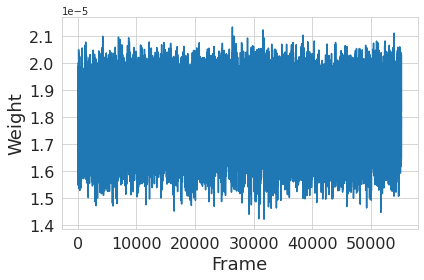

In [103]:
plt.plot(final_weights)
plt.ylabel('Weight',size=18)
plt.xlabel('Frame',size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='16')
plt.yticks(size='16')
plt.tight_layout()
plt.savefig('%s/FrameWeights.png'%outdir)
plt.show()

In [104]:
exp=[]
calc=[]
rmsdin = []
rmsdf = []
for t in Reweight_Data:
 if t!='Rg':
  print(t)
  resid=[]
    
  err_fit=[]    
  err=err_d[t]
  for i,id in enumerate(compare_dict_r[t]): 
   resid.append(float(id))
   #exp.append(compare_dict_r[t][id][0]) 
   #err_fit.append(err)
  initial=np.trim_zeros(initial_obs_r*data_r_type[t])
  reweight=np.trim_zeros(final_obs_r*data_r_type[t])
  exp=np.trim_zeros(obs_exp_r*data_r_type[t])
  err=err_d[t]
  rmsd_i=(sum(np.square(initial-exp))/len(exp))**0.5
  rmsd_f=(sum(np.square(reweight-exp))/len(exp))**0.5
  print("RMSD_initial:%6.3lf" %rmsd_i,"RMSD_final:%6.3lf"%rmsd_f)
  rmsdin.append(rmsd_i)
  rmsdf.append(rmsd_f)

C7
RMSD_initial: 0.128 RMSD_final: 0.010
C8
RMSD_initial: 0.050 RMSD_final: 0.030
C9
RMSD_initial: 0.045 RMSD_final: 0.025
C10
RMSD_initial: 0.041 RMSD_final: 0.023
C17
RMSD_initial: 0.194 RMSD_final: 0.013
C18
RMSD_initial: 0.633 RMSD_final: 0.040


In [105]:
rmsdin_arr = np.asarray(rmsdin)
rmsdf_arr = np.asarray(rmsdf)
av_rmi = np.average(rmsdin_arr)
av_rmf = np.average(rmsdf_arr)

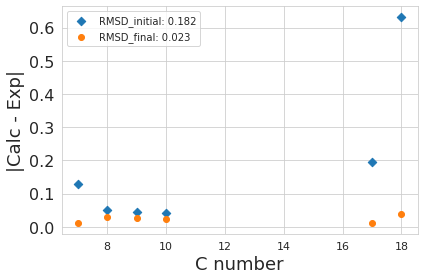

In [106]:
plt.scatter(scaflist, rmsdin, marker = 'D', label="RMSD_initial:%6.3lf"%av_rmi)
plt.scatter(scaflist, rmsdf, marker = 'o', label= "RMSD_final:%6.3lf"%av_rmf)
plt.tick_params(axis='x', which='major', labelsize=8)
#plt.xticks(scaflist)
plt.ylabel('|Calc - Exp|',size=18)
plt.xticks(fontsize=11)
plt.yticks(fontsize=16)
plt.xlabel('C number',size=18)
plt.legend(loc='upper left')
plt.tight_layout()  

In [107]:
#Plot Fitting Data
initialdata =[]
reweightdata = []

calc=[]    
err_fit=[]    
err=err_d[t]
for t in Reweight_Data:
 if t!='Rg':
  #print(t)
  resid=[]
  exp=[]
  for i,id in enumerate(compare_dict_r[t]): 
   resid.append(float(id))
   exp.append(compare_dict_r[t][id][0]) 
   err_fit.append(err)
  initial=np.trim_zeros(initial_obs_r*data_r_type[t])
  reweight=np.trim_zeros(final_obs_r*data_r_type[t])
  initialdata.append(initial)
  reweightdata.append(reweight)

In [108]:
rewtlist = ["C{}".format(i) for i in scaflist]
explist = [expdata[key]["1.0"] for key in rewtlist]

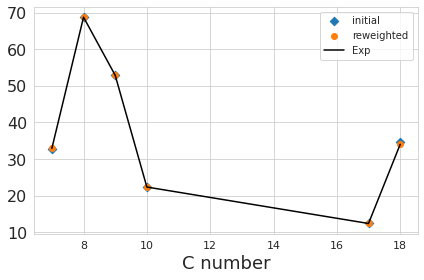

In [109]:
plt.scatter(scaflist, initialdata, marker = 'D', label="initial")
plt.scatter(scaflist, reweightdata, marker = 'o', label= "reweighted")
plt.plot(scaflist, explist, label='Exp', color="black")
plt.tick_params(axis='x', which='major', labelsize=8)
#plt.xticks(scaflist)
plt.xticks(fontsize=11)
plt.yticks(fontsize=16)
plt.xlabel('C number',size=18)
plt.legend(loc='upper right')
plt.tight_layout() 

In [111]:
w=np.loadtxt('nmrgnn/reweighting/output/weights_final_2.dat') #weights_from_just_aromatic_Cs

In [112]:
phis = []
phis_1 = []
for i in range(len(phi)):
    phis.append(phi[i][0])
for i in range(len(phi_1)):
    phis_1.append(phi_1[i][0])
    
phis_arr = np.asarray(phis)
phis_1_arr = np.asarray(phis_1)

/home/exx/miniconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


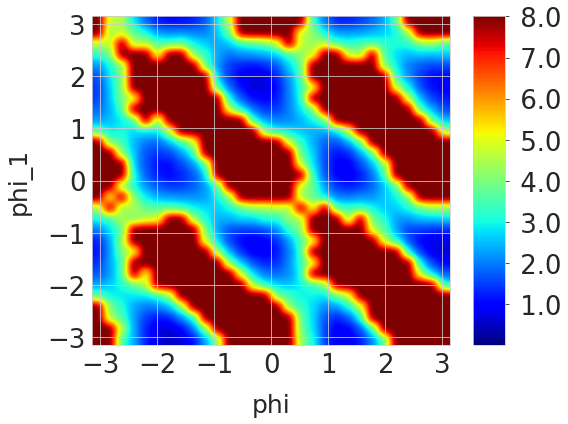

/home/exx/miniconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


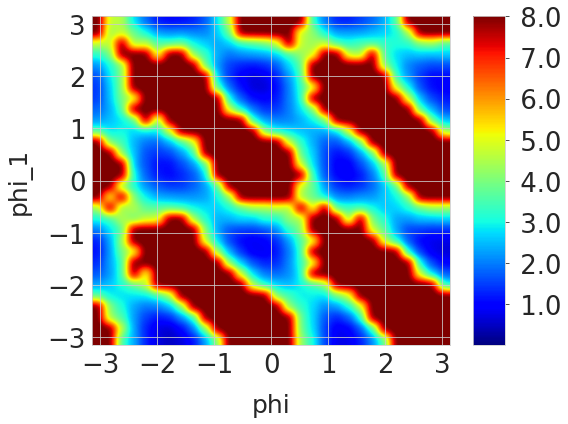

In [115]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

#Lets Look at The Biased and Unbiased Distributions of the Dihedral Angles
dG,xedges,yedges=free_energy(phis_arr,phis_1_arr, 300, -3.14, 3.14, -3.14, 3.14)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-3.14,3.14)
plt.ylim(-3.14,3.14)

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("phi_1", size=25, labelpad=15)
plt.xlabel("phi", size=25, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()

def free_energy_weights(a, b, T, y0, ymax, x0, xmax,w):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=w)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

dG,xedges,yedges=free_energy_weights(phis_arr,phis_1_arr, 300, -3.14, 3.14, -3.14, 3.14,w)
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-3.14,3.14)
plt.ylim(-3.14,3.14)

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("phi_1", size=25, labelpad=15)
plt.xlabel("phi", size=25, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()

/home/exx/miniconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


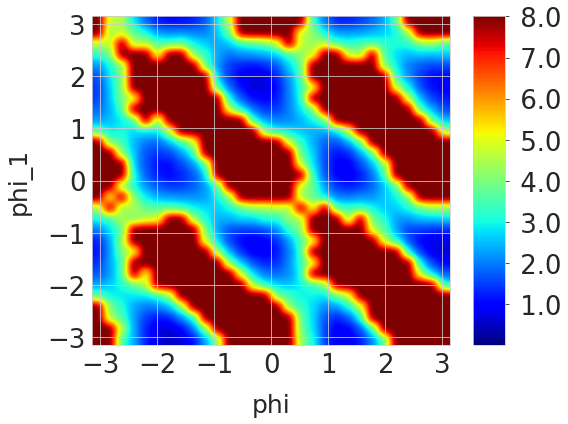

/home/exx/miniconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


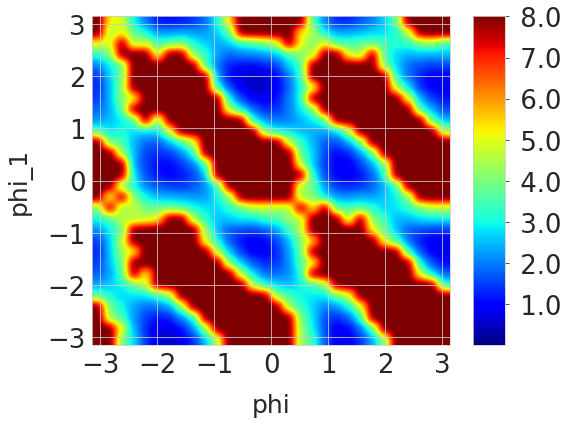

In [126]:
w1=np.loadtxt('nmrgnn/reweighting/output/weights_final.dat') #weights_from_all_Cs

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

#Lets Look at The Biased and Unbiased Distributions of the Dihedral Angles
dG,xedges,yedges=free_energy(phis_arr,phis_1_arr, 300, -3.14, 3.14, -3.14, 3.14)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-3.14,3.14)
plt.ylim(-3.14,3.14)

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("phi_1", size=25, labelpad=15)
plt.xlabel("phi", size=25, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()

def free_energy_weights(a, b, T, y0, ymax, x0, xmax,w):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=w1)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

dG,xedges,yedges=free_energy_weights(phis_arr,phis_1_arr, 300, -3.14, 3.14, -3.14, 3.14,w)
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-3.14,3.14)
plt.ylim(-3.14,3.14)

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("phi_1", size=25, labelpad=15)
plt.xlabel("phi", size=25, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()

WE CAN OBSERVE THE SAME PHI/PHI_1 ENERGY PLOT FOR BOTH REWEIGHTING AND THEY ARE UNCHANGED. 
SO I AM CHECKING BELOW WHETHER THE WEIGHTS ARE EXACTLY THE SAME FOR BOTH CASES WHICH DOES NOT SEEM TO BE.
MAYBE THE ISSUE IS I AM USING TWO SETS OF PHI (TWO DIFFERENT DIHEDRALS) AND THEY ARE PRETTY SIMILAR 
IN VALUES? (SO WE ARE NOT SEEING ANY DIFFERENT FREE ENERGY PLOT FOR THEM)

In [122]:
print((np.max(w),np.min(w)))

(2.1342943e-05, 1.4228586e-05)


In [123]:
print((np.max(w1),np.min(w1)))

(0.000164063842, 1.148544e-06)


In [131]:
print(np.max(phis_arr), np.max(phis_1_arr))

3.1415718 3.1415434


In [132]:
print(np.min(phis_arr),np.min(phis_1_arr))

-3.1415908 -3.1415691


AS WE CAN SEE THE MAX AND MIN VALUES OF PHI AND PHI_1 ARE QUITE CLOSE BUT NOT THE SAME. MAYBE DUE TO SIMILAR DISTRIBUTION OF BOTH WE OBSERVE WHAT WE ARE SEEING IN THE FREE ENERGY PLOT.